In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import time

mapping, inv_mapping = [], []

def num_entries(k, N):
    if 0 <= k <= N - 1:
        return int(1./2 * (k+1) * (k+2))
    elif N <= k <= 2*N - 3:
        return int(1./2 * (-2*k**2 + 6*k*N - 6*k - 3*N**2 +9*N - 4))
    elif 2*N - 2 <= k <= 3*N - 3:
        return int(1./2 * (3*N - 2 - k) * (3*N - 1 - k))
    else:
        return 0


def generate_triples(N, total):
    # List containing generated triples
    gen = []

    
    if 0 <= total <= N - 1:
        # Generate first element
        i, j, k = (0, 0, total)
        while i <= total:
            # print ("now i is", i)
            while j <= total - i:
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            j = 0
            k = total - i
            
                # pass

    elif N <= total <= 2*N - 3:
        # Generate first element
        i, j, k = (0, total-N+1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k


            
    elif 2*N - 2 <= total <= 3*N - 3:
        # Generate first element
        i, j, k = (total - 2*N + 2, N-1, N-1)
        while i <= N-1:
            while j <= min(N-1, total - i):
                gen.append ((i, j, k))
                j += 1
                k -= 1
            i += 1
            k = min(N-1, total - i)
            j = total - i - k
        
    else:
        raise ValueError("Not applicable k")

    return gen

def index_triple_maps(N):
    mapping = {}
    inv_mapping = {}
    for k in range(3*N - 2):
        triples = generate_triples(N, k)
        mapping[k] = {i: triples[i] for i in range(len(triples))}
        inv_mapping[k] = {triples[i]: i for i in range(len(triples))}
    return mapping, inv_mapping

def omit_sites(inv_mapping, omit):    
    site = 0
    new_inv_map = {}
    new_map = {}
    
    for sum_ in inv_mapping.keys():
        inv_sum_k_sites = {}
        sum_k_sites = {}
        site_index = 0
        for triple in inv_mapping[sum_].keys():
            if omit[site] == 1:
                inv_sum_k_sites[triple] = site_index
                sum_k_sites[site_index] = triple
                site_index += 1
            else:
                x, y, z = triple
#                 print ("I'm omitting", triple)
            site += 1
        new_inv_map[sum_] = inv_sum_k_sites
        new_map[sum_] = sum_k_sites

    return new_map, new_inv_map, x, y, z




def calculate(z_n, t_n = 1.0, e_n = 1.0, N = 20, k = 1, c = complex,
                           mapping = mapping, inv_mapping = inv_mapping):

    

    amplitude = t_n / (z_n - e_n)
    print (amplitude)
    # amplitude = 1
    a = {}
    b = {}


    for k in range(3*N-2):
        alpha_num_entries = len(inv_mapping[k-1]) if k > 0 else 0
        my_entries = len(inv_mapping[k])
        beta_num_entries = len(inv_mapping[k+1]) if k < 3*N - 3 else 0
        a_k = np.zeros((my_entries, alpha_num_entries), dtype=c)
        b_k = np.zeros((my_entries, beta_num_entries), dtype=c)
        for index, triple in mapping[k].items():
            x, y, z = triple

            # Calculate b_k
            if k < 3*N - 3:
                if x < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x + 1, y, z]] = amplitude
                    except:
                        pass
                    
                if y < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y + 1, z]] = amplitude
                    except:
                        pass

                if z < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y, z + 1]] = amplitude
                    except:
                        pass
#             # Calculate a_k
            if 0 < k:
                if x > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x - 1, y, z]] = amplitude
                    except:
                        pass

                if y > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y - 1, z]] = amplitude
                    except:
                        pass

                if z > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y, z - 1]] = amplitude
                    except:
                        pass

        a[k] = a_k
        b[k] = b_k
#         print (k, a_k)

# Calculate C
    x_, y_, z_ = (10,10,10)
    sum_ = sum([x_, y_, z_])
    C = np.zeros(shape = (num_entries(sum_, N), 1), dtype = complex)
    C[inv_mapping[sum_][(x_, y_, z_)]] = 1. / (z_n - e_n)



    # Calculate Multiplicative Factors 
    A = {}
    G = {}
    A[1] = b[1]
    
    for k in range(2, sum_):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), b[k])
        # G[k] = np.linalg.solve(np.eye(num_entries(k, N)) - a[k].dot(A[k - 1]), (a[k].dot(G[k-1]))) 


    A[3*N - 4] = a[3*N - 4]
    for k in range(3*N - 5, sum_, -1):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), a[k])

    
    # Calculate Green's Functions
    V = {}
    k = sum_
    V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]) - b[k].dot(A[k + 1]), 
                           C)

    for k in range(sum_ + 1, 46):
        V[k] = A[k].dot(V[k - 1])


    print ([len(inv_mapping[k]) for k in range(3*N-2)])
    return V[45][inv_mapping[45][(15,15,15)]]
    

In [ ]:
N = 20

mapping, inv_mapping = index_triple_maps(N)
# mapping
# omit = np.full(N**3, 1)
# omit[0] = 0
# mapping, inv_mapping = omit_sites(inv_mapping, omit)
# mapping
# v=0
# for key in mapping.keys():
#     for s in (mapping[key]):
#         v += 1
# print (v)
# # print (omit)
# # print (mapping)

# tic = time.time()

array4 = []
# # # for w in np.linspace(-20, 20, 100):
array4.append (calculate(3+0.1j, N = 20, c = complex, mapping = mapping, inv_mapping = inv_mapping))
print (array4)

mapping, inv_mapping = index_triple_maps(N)
omit = np.full(N**3, 1)
omit[1000] = 0

mapping, inv_mapping, a1,a2,a3 = omit_sites(inv_mapping, omit)
array4 = []
# # # # for w in np.linspace(-20, 20, 100):
array4.append (calculate( 3+0.1j, N = 20, c = complex, mapping = mapping, inv_mapping = inv_mapping))
print (array4)

In [2]:
def _calculate(z_n, x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, t_n = 1.0, e_n = 1.0, N = 20, k = 1, c = complex,
                           mapping = mapping, inv_mapping = inv_mapping):

    

    amplitude = t_n / (z_n - e_n)
    # amplitude = 1
    a = {}
    b = {}


    for k in range(3*N-2):
        alpha_num_entries = len(inv_mapping[k-1]) if k > 0 else 0
        my_entries = len(inv_mapping[k])
        beta_num_entries = len(inv_mapping[k+1]) if k < 3*N - 3 else 0
        a_k = np.zeros((my_entries, alpha_num_entries), dtype=c)
        b_k = np.zeros((my_entries, beta_num_entries), dtype=c)
        for index, triple in mapping[k].items():
            x, y, z = triple

            # Calculate b_k
            if k < 3*N - 3:
                if x < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x + 1, y, z]] = amplitude
                    except:
                        pass
                    
                if y < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y + 1, z]] = amplitude
                    except:
                        pass

                if z < N - 1:
                    try:
                        b_k[index, inv_mapping[k + 1][x, y, z + 1]] = amplitude
                    except:
                        pass
#             # Calculate a_k
            if 0 < k:
                if x > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x - 1, y, z]] = amplitude
                    except:
                        pass

                if y > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y - 1, z]] = amplitude
                    except:
                        pass

                if z > 0:
                    try:
                        a_k[index, inv_mapping[k - 1][x, y, z - 1]] = amplitude
                    except:
                        pass

        a[k] = a_k
        b[k] = b_k

    # Calculate C
    sum_ = sum([x_, y_, z_])
    
    C = np.zeros(shape = (len(inv_mapping[sum_]), 1), dtype = complex)
    C[inv_mapping[sum_][(x_, y_, z_)]] = 1. / (z_n - e_n)
    
        



    # Calculate Multiplicative Factors 
    A = {}
    G = {}
    A[1] = b[1]
    
    for k in range(2, sum_):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), b[k])


    A[3*N - 4] = a[3*N - 4]
    for k in range(3*N - 5, sum_, -1):
        A[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), a[k])

    
    # Calculate Green's Functions
    V = {}
    k = sum_
    try:
        if 1 < k < 3*N-4:
            V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]) - b[k].dot(A[k + 1]), 
                               C)
        elif k == 1:
            V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - b[k].dot(A[k + 1]), 
                               C)
        elif k == 3*N - 4:
            V[k] = np.linalg.solve(np.eye(len(inv_mapping[k])) - a[k].dot(A[k - 1]), 
                               C)
            
    except:
        print ("x_t, y_t, z_t, x_, y_, z_:", x_t, y_t, z_t, x_, y_, z_)
        print ("I'm omitting:", x_o, y_o, z_o)
        print (len(inv_mapping[k]))
        print (a[k].shape,a[k])
        print (A[k-1].shape, A[k-1])
        print (b[k].shape,b[k])
        print (A[k+1].shape, A[k+1])
        print (C.shape, C)
        print (inv_mapping[sum_])
        raise ValueError
    if x_t + y_t + z_t > sum_:
        for k in range(sum_ + 1, x_t + y_t + z_t + 1):
            V[k] = A[k].dot(V[k - 1])
    elif x_t + y_t + z_t < sum_:
        for k in range(sum_ - 1, x_t + y_t + z_t - 1, -1):
            V[k] = A[k].dot(V[k + 1])

    return V[x_t + y_t + z_t]

In [47]:
N=20
mapping, inv_mapping = index_triple_maps(N)
X = []
Y = []
x_t, y_t, z_t, x_, y_, z_ = np.random.randint(20, size=6)
energy = np.random.uniform(-1, 1) 

for _ in range(N**3):
    if x_ + y_ + z_ == 3*N - 3:
        continue
    elif (x_ == x_o) & (y_ == y_o) & (z_ == z_o):
        continue
    omit = np.full(N**3, 1)
    omit[_] = 0
    _mapping, _inv_mapping, x_o, y_o, z_o = omit_sites(inv_mapping, omit)
    
    print (x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, energy)
    true_value = (_calculate(energy+0.1j, x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, mapping = mapping, inv_mapping = inv_mapping))
    if x_o + y_o + z_o == x_t + y_t + z_t:
        true_value = np.delete(true_value, inv_mapping[x_o + y_o + z_o][(x_o, y_o, z_o)])
        true_value = true_value[:,np.newaxis]

    predicted_value = (_calculate(energy+0.1j, x_t, y_t, z_t, x_, y_, z_, x_o, y_o, z_o, mapping = _mapping, inv_mapping = _inv_mapping))
    
        
    error = np.absolute((predicted_value - true_value) / true_value * 100)[_inv_mapping[x_t+ y_t+ z_t][(x_t, y_t, z_t)]]
#     for index, triple in enumerate(_inv_mapping[x_t + y_t + z_t].keys()):
#         (x, y, z) = triple
#         x, y, z, x__, y__, z__, x_o_, y_o_, z_o_ = (np.array([x, y, z, x_, y_, z_, x_o, y_o, z_o], dtype=float) / 10.0) - 1
#         X.append([x, y, z, x__, y__, z__, x_o_, y_o_, z_o_, energy])
    X.append(_)
    Y.append(error)

X = np.array(X)
print ("Error shapes", [ (i).shape for i in Y])
Y_ = np.concatenate(Y)
# Y_ = (Y_ - np.mean(Y_))/np.std(Y_)
Y_.shape

6 14 10 2 16 16 0 0 0 0.8658544504610024
6 14 10 2 16 16 0 0 1 0.8658544504610024
6 14 10 2 16 16 0 1 0 0.8658544504610024
6 14 10 2 16 16 1 0 0 0.8658544504610024
6 14 10 2 16 16 0 0 2 0.8658544504610024
6 14 10 2 16 16 0 1 1 0.8658544504610024
6 14 10 2 16 16 0 2 0 0.8658544504610024
6 14 10 2 16 16 1 0 1 0.8658544504610024
6 14 10 2 16 16 1 1 0 0.8658544504610024
6 14 10 2 16 16 2 0 0 0.8658544504610024
6 14 10 2 16 16 0 0 3 0.8658544504610024
6 14 10 2 16 16 0 1 2 0.8658544504610024
6 14 10 2 16 16 0 2 1 0.8658544504610024
6 14 10 2 16 16 0 3 0 0.8658544504610024
6 14 10 2 16 16 1 0 2 0.8658544504610024
6 14 10 2 16 16 1 1 1 0.8658544504610024
6 14 10 2 16 16 1 2 0 0.8658544504610024
6 14 10 2 16 16 2 0 1 0.8658544504610024
6 14 10 2 16 16 2 1 0 0.8658544504610024
6 14 10 2 16 16 3 0 0 0.8658544504610024
6 14 10 2 16 16 0 0 4 0.8658544504610024
6 14 10 2 16 16 0 1 3 0.8658544504610024
6 14 10 2 16 16 0 2 2 0.8658544504610024
6 14 10 2 16 16 0 3 1 0.8658544504610024
6 14 10 2 16 16 

KeyError: (6, 14, 10)

Text(0.5,1,'Relative error of <10, 15, 18|G|14, 13, 10>, omitting <6, 1, 1|G|14, 13, 10>')

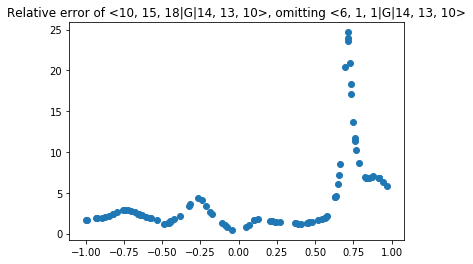

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X, Y_)
# plt.ylim(0, 100)
plt.title("Relative error of <10, 15, 18|G|14, 13, 10>, omitting <6, 1, 1|G|14, 13, 10>")

Text(0.5,1,'Relative error of <16, 0, 19|G|3, 7, 18>, omitting <3, 5, 10|G|3, 7, 18>')

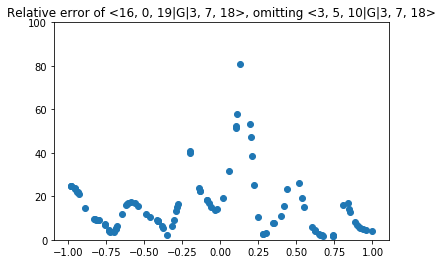

In [32]:
plt.scatter(X, Y_)
plt.ylim(0, 100)
plt.title("Relative error of <16, 0, 19|G|3, 7, 18>, omitting <3, 5, 10|G|3, 7, 18>")

In [17]:
np.set_printoptions(precision=3, suppress=True)
print(np.concatenate(Y)[21*0:21*1])
print(np.concatenate(Y)[21*1:21*2])
# print(np.concatenate(Y)[21*2:21*3])
# print(np.concatenate(Y)[21*3:21*4])
print(np.concatenate(Y)[21*4:21*5])

[[ 3.019]
 [ 7.015]
 [ 1.302]
 [ 3.456]
 [ 1.922]
 [ 0.254]
 [ 2.949]
 [ 7.684]
 [ 1.898]
 [ 0.29 ]
 [ 2.025]
 [ 2.517]
 [ 0.544]
 [ 0.91 ]
 [ 0.245]
 [ 0.408]
 [ 0.538]
 [ 0.89 ]
 [ 6.417]
 [ 0.706]
 [ 0.397]]
[[ 2.27 ]
 [ 0.248]
 [ 0.235]
 [ 1.476]
 [ 1.218]
 [ 0.837]
 [ 1.989]
 [ 0.988]
 [ 0.142]
 [ 0.225]
 [ 5.765]
 [ 1.096]
 [ 0.366]
 [ 0.533]
 [ 0.371]
 [ 0.156]
 [ 0.668]
 [ 0.745]
 [ 0.224]
 [ 0.208]
 [ 0.259]]
[[ 0.633]
 [ 0.29 ]
 [ 0.736]
 [ 1.216]
 [ 0.735]
 [ 0.331]
 [ 0.657]
 [ 0.461]
 [ 1.312]
 [ 0.678]
 [ 0.097]
 [ 0.457]
 [ 0.788]
 [ 0.224]
 [ 0.164]
 [ 0.158]
 [ 0.436]
 [ 2.028]
 [ 0.385]
 [ 0.4  ]
 [ 0.036]]


In [ ]:
Y_ = np.concatenate(Y)
Y_ = (Y_ - np.mean(Y_))/np.std(Y_)
Y_.shape

In [ ]:
from sklearn import preprocessing
Y_ = preprocessing.normalize(Y_)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y_, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
import keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

seed = 7
np.random.seed(seed)



def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
estimator = KerasRegressor(build_fn=baseline_model, epochs=650, batch_size=50, verbose=1)

kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [ ]:
model = Sequential()
model.add(Dense(10, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
print(model.summary())